# Data Analysis Plan: Foreign Exchange Analysis

# Team 6
- Mahek Aggarwal
- John Gemmell
- Jacob Kulik
- David Pogrebitskiy


# Project Goal:
This Project aims to use exchangerate.host, a free foreign exchange and crypto API,
to understand how different currencies change and in relation to others and if a movement in
one can help predict a movement in another. By analysing trends and volatility, we will be able
to understand which currencies trigger a global movement, which ones tend to follow afterwards, and
be able to predict a currency's direction if we see a movement in a currency that it tracks.

# Data:
## Overview:

We will request Foreign Exchange values for a variety of different currencies and cryptos
from the ExchangeRate API. Our data will include both major and minor currencies that are pegged to/track
the currencies of first-world countries. Because the data coming from the API is in a time-series format,
we will be able to look at a variety of different period lengths between observations to see
which length best suits our needs.
# Pipeline Overview:
## API and Formating Functions:
- `api_req()`
    - makes an initial request to the API that includes time-series data of all of our
    desired parameters using Python's kwargs feature

- `merge_df_by_year()`
    - Merge multiple years worth of data into one dataframe because the API limits us
    to 2 years of data per call

## Analysis and Visualizations:
- `scale_cur()`
    - scales the currencies to be between 0 and 1, helping with plotting and analyzing
- `moving_avg()`
    - calculates a moving average function for a certain currency
- `calc_pct_change()`
    - calculating the percentage change between values, helping normalize and analyse
    
## Machine Learning
- `r2_scoring()`
    - Calculates R2 of cross-validated model
- `randomness_test()`
    - Checks variable independence, constant variance, and normality assumptions for linear regression
- `get_mse()`
    - Calculate the Mean Squared Error between true and predicted values
- `show_fit()`
    - Plot the fit of the linear regression with associated metrics

In [1]:
import requests
from pprint import pprint
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.linear_model import LinearRegression
import pylab as py
import scipy.stats as stats
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

In [2]:
def api_req(**kwargs):
    '''
    This function calls an exchange rate api and builds a df with the data
    A list of strings (currencies) is a parameter
    returns a transpose dataframe where the dates are the indices

    Params for API call kwargs:
        start_date [required] String format (YYYY-MM-DD)
        end_date [required] String format (YYYY-MM-DD)
        base. example:base=USD
        symbols	[optional] Enter a list of comma-separated currency codes to limit output
            currencies. example:symbols=USD,EUR,CZK
        amount	[optional] The amount to be converted. example:amount=1200
        places	[optional] Round numbers to decimal place. example:places=2
        source	[optional] You can switch source data between (default) forex, bank view or crypto currencies. (ecb, crypto)
    '''

    params = kwargs
    url = 'https://api.exchangerate.host/timeseries?'
    
    # Query the API call
    response = requests.get(url, params=params)
    data = response.json()

    return pd.DataFrame(data['rates']).T

api_req(start_date='2021-01-01', end_date='2022-01-01', base='USD', symbols='GBP,RUB,EUR,DKK')

,DKK,EUR,GBP,RUB
2021-01-01,6.092900,0.821300,0.731368,73.944993
2021-01-02,6.092899,0.824063,0.731368,73.944989
2021-01-03,6.082472,0.817388,0.731935,74.108816
2021-01-04,6.073148,0.816286,0.736620,73.532982
2021-01-05,6.049919,0.813219,0.734071,74.170118
...,...,...,...,...
2021-12-28,6.571598,0.884210,0.744312,73.642400
2021-12-29,6.548574,0.880921,0.741268,73.951951
2021-12-30,6.560552,0.882704,0.740360,74.703970
2021-12-31,6.538054,0.879286,0.739386,74.767039


In [3]:
def merge_df_by_years(start_year, end_year, **kwargs):
    '''
    Creates a dataframe containing the exchange rates from the start year to the end year.
    Merge multiple years worth of data into one dataframe from the API call because it limits
    the amount of row in a request.
    :param start_year (int):
    :param end_year (int):
    
    :return: DataFrame
    '''

    df_output = pd.DataFrame()
    
    # Iterate through the the desired years
    for year in range(start_year, end_year + 1):
        params = {
            'start_date': f'{year}-01-01',
            'end_date': f'{year}-12-31',
        }
        # Update the params with the other input params
        kwargs.update(params)
        df_year = api_req(**kwargs)
        
        # Stack all the dataframes because of the API limitting
        df_output = pd.concat([df_output, df_year])
    df_output.dropna(inplace=True, axis=0)
    return df_output

df = merge_df_by_years(2010, 2022, symbols='GBP,EUR,RUB,JPY,AUD,DKK', base='USD') 
df

,JPY,DKK,GBP,RUB,AUD,EUR
2010-01-01,92.918694,5.171022,0.618138,29.988881,1.113482,0.694927
2010-01-02,92.918694,5.171022,0.618138,29.988881,1.113482,0.694927
2010-01-03,92.918694,5.171022,0.618138,29.988881,1.113482,0.694927
2010-01-04,92.477815,5.158902,0.620632,30.297421,1.095743,0.693289
2010-01-05,91.556453,5.179730,0.625226,29.990185,1.096478,0.696088
...,...,...,...,...,...,...
2022-11-14,140.024005,7.205259,0.850532,61.358057,1.492948,0.968843
2022-11-15,139.151797,7.182150,0.842696,60.688715,1.479230,0.966175
2022-11-16,139.449689,7.155186,0.839162,60.519347,1.484303,0.962647
2022-11-17,140.310746,7.179122,0.843316,60.489288,1.496083,0.965755


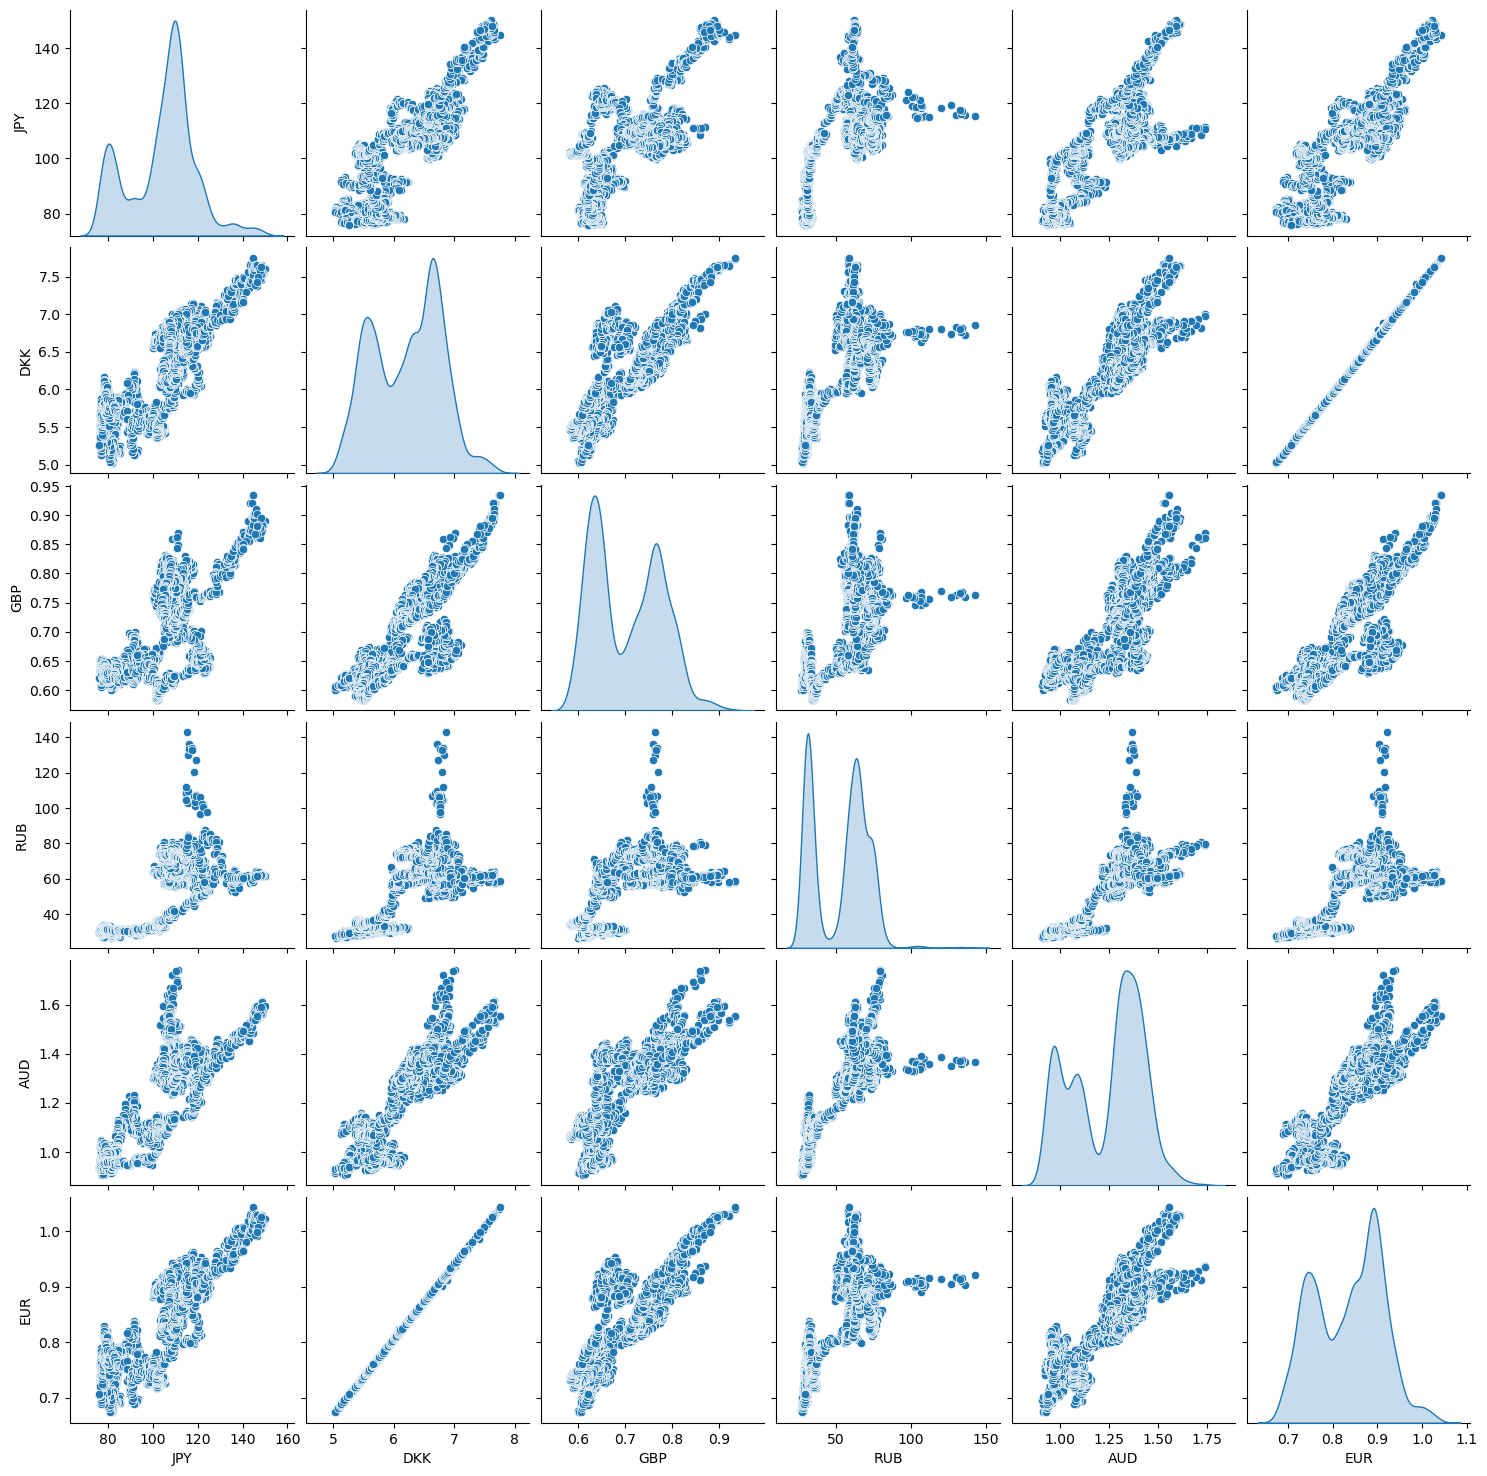

In [4]:
sns.pairplot(df, diag_kind='kde')
plt.show()

In [5]:
def scale_cur(df):
    '''
    Scales the exchange rates for a dataframe of currencies
    df- dataframe
    returns a scaled dataframe
    '''

    cols = df.columns
    # fitting a scaler to make the data comparable visually
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df.to_numpy())
    df_scaled = pd.DataFrame(df_scaled, columns=cols)

    # updating indexes to be dates
    df_scaled.index = df.index
    return df_scaled

df_scaled = scale_cur(df)
df_scaled

,JPY,DKK,GBP,RUB,AUD,EUR
2010-01-01,0.231092,0.053851,0.100801,0.028231,0.248591,0.057518
2010-01-02,0.231092,0.053851,0.100801,0.028231,0.248591,0.057518
2010-01-03,0.231092,0.053851,0.100801,0.028231,0.248591,0.057518
2010-01-04,0.225159,0.049412,0.107887,0.030892,0.227344,0.053085
2010-01-05,0.212761,0.057041,0.120938,0.028243,0.228224,0.060660
...,...,...,...,...,...,...
2022-11-14,0.864962,0.798867,0.761014,0.298752,0.703100,0.798791
2022-11-15,0.853225,0.790403,0.738752,0.292979,0.686669,0.791571
2022-11-16,0.857234,0.780528,0.728712,0.291519,0.692745,0.782023
2022-11-17,0.868821,0.789294,0.740513,0.291260,0.706855,0.790434


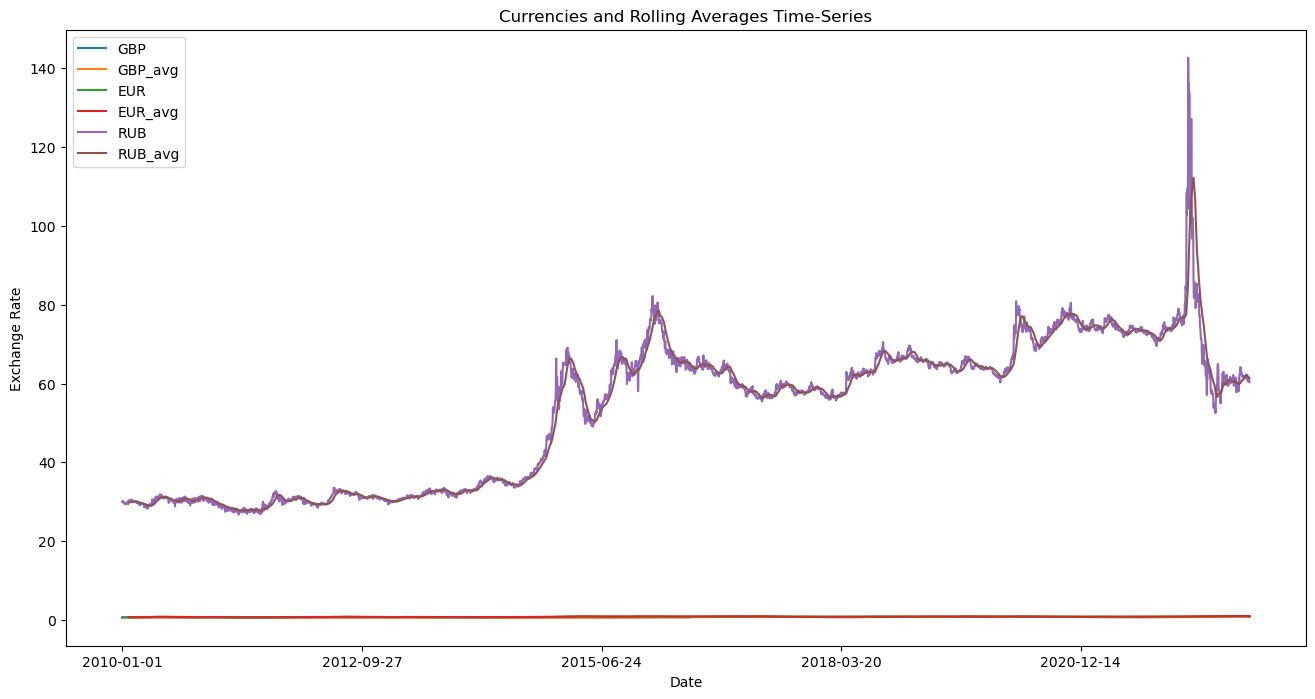

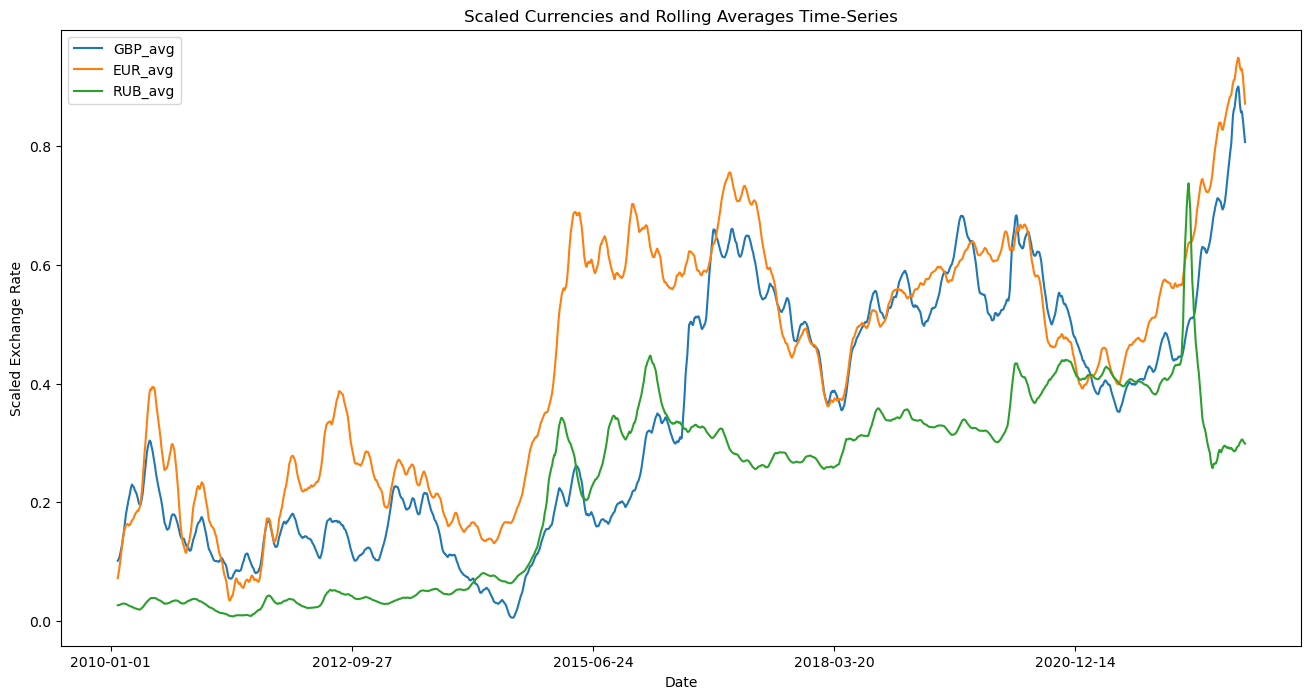

In [6]:
def moving_avg(df, roll, *curs, scale=True):
    '''
    Creates a moving average plot for a given number of currencies and their moving averages
    df - dataframe, roll - int and number of days to be smoothed, *curs - list of currencies
    returns an updated df and a plot
    '''
    fig, ax = plt.subplots()

    # Creating label based off graph type
    plt.xlabel('Date')
    if scale:
        plt.ylabel('Scaled Exchange Rate')
        plt.title('Scaled Currencies and Rolling Averages Time-Series')
    else:
        plt.ylabel('Exchange Rate')
        plt.title('Currencies and Rolling Averages Time-Series')

    # iterating across currencies
    for cur in curs:
        cur_idx = cur + '_avg'
        # creating a rolling mean column and plotting both
        df[cur_idx] = df[cur].rolling(roll).mean()
        if scale:
            df[[cur_idx]].plot(ax=ax,label='ROLLING AVERAGE',
                                  figsize=(16, 8))
        else:
            df[[cur, cur_idx]].plot(ax=ax,label='ROLLING AVERAGE',
                                  figsize=(16, 8))
    return df

df_usd = moving_avg(df, 30,'GBP','EUR','RUB', scale=False)
df_usd_scaled = moving_avg(df_scaled, 30, 'GBP', 'EUR', 'RUB', scale=True)
plt.show()

## Important Note:
Although scaled, the y-axis still represents the exchange rate in relation to the US Dollar. In other words, when a currencie's exchange rate is incresasing on the chart, it's value lessens because it takes more of that currency to trade for $1. Because of this, movements are interpreted opposite to your intution. Decrease is good and increase is bad.


## Interpretation:
By exploring the above graph, we can see a few key takeaways. First, we can see very clearly that global events and/or crises can be seen reflected on a countries exchange rate plot. Namely, we can see the European Debt Crisis in 2015, Brexit at the end of 2020, and Russia's economic downfall after their invasion of Ukraine. Additionally, by looking at these exchange rates on top of each other, we can begin to see the relationships between currencies. Specificically, we can see that the overall, long-term trend of each currency decreases in value. Looking closely, we can see that GBP tends to follow EUR but not immediately. In other words, GBP has s

In [7]:
def calc_pct_change(df):
    """
    Calculates the pct change between each observation in the dataframe
    Params:
        df(DataFrame): a dataframe of time-series exchange rates
    """
    pct_df = df.pct_change()
    
    # Rename each of the columns for the pct change
    for col in pct_df.columns:
        pct_df.rename(columns={col: col+"_pct_change"}, inplace=True)
    
    # Concat the original with pct change df
    return pct_df, pd.concat([df, pct_df], axis=1)

pct_df, pct_concated = calc_pct_change(df)

# Analysis Plan:

* We plan to analyze our time-series data of the currencies using different regression models such as linear regression, polynomial regression, and KNN regression and comparing these models to determine which one yields the best results for a predictive model.

* We can incorporate our scaled exchange rate info to make more sense of currency pegs and the fluctuation of excgange rates

* We can incorporate a cryptocurrency analysis as well, seeing how accurate different models are for crypto

* We also plan on analyzing the seasonality of how these currencies move to potentially see if we can identify any cycles that can help us predict a movement direction.

* Adding on, we can incoroprate more interactive plots, such as plotly dash, to allow a user to interact with our times-series data and play around with certain parameters

* Additionally, the correlation of various currencies can be calculated and analyzed to determine which currencies track with one another 

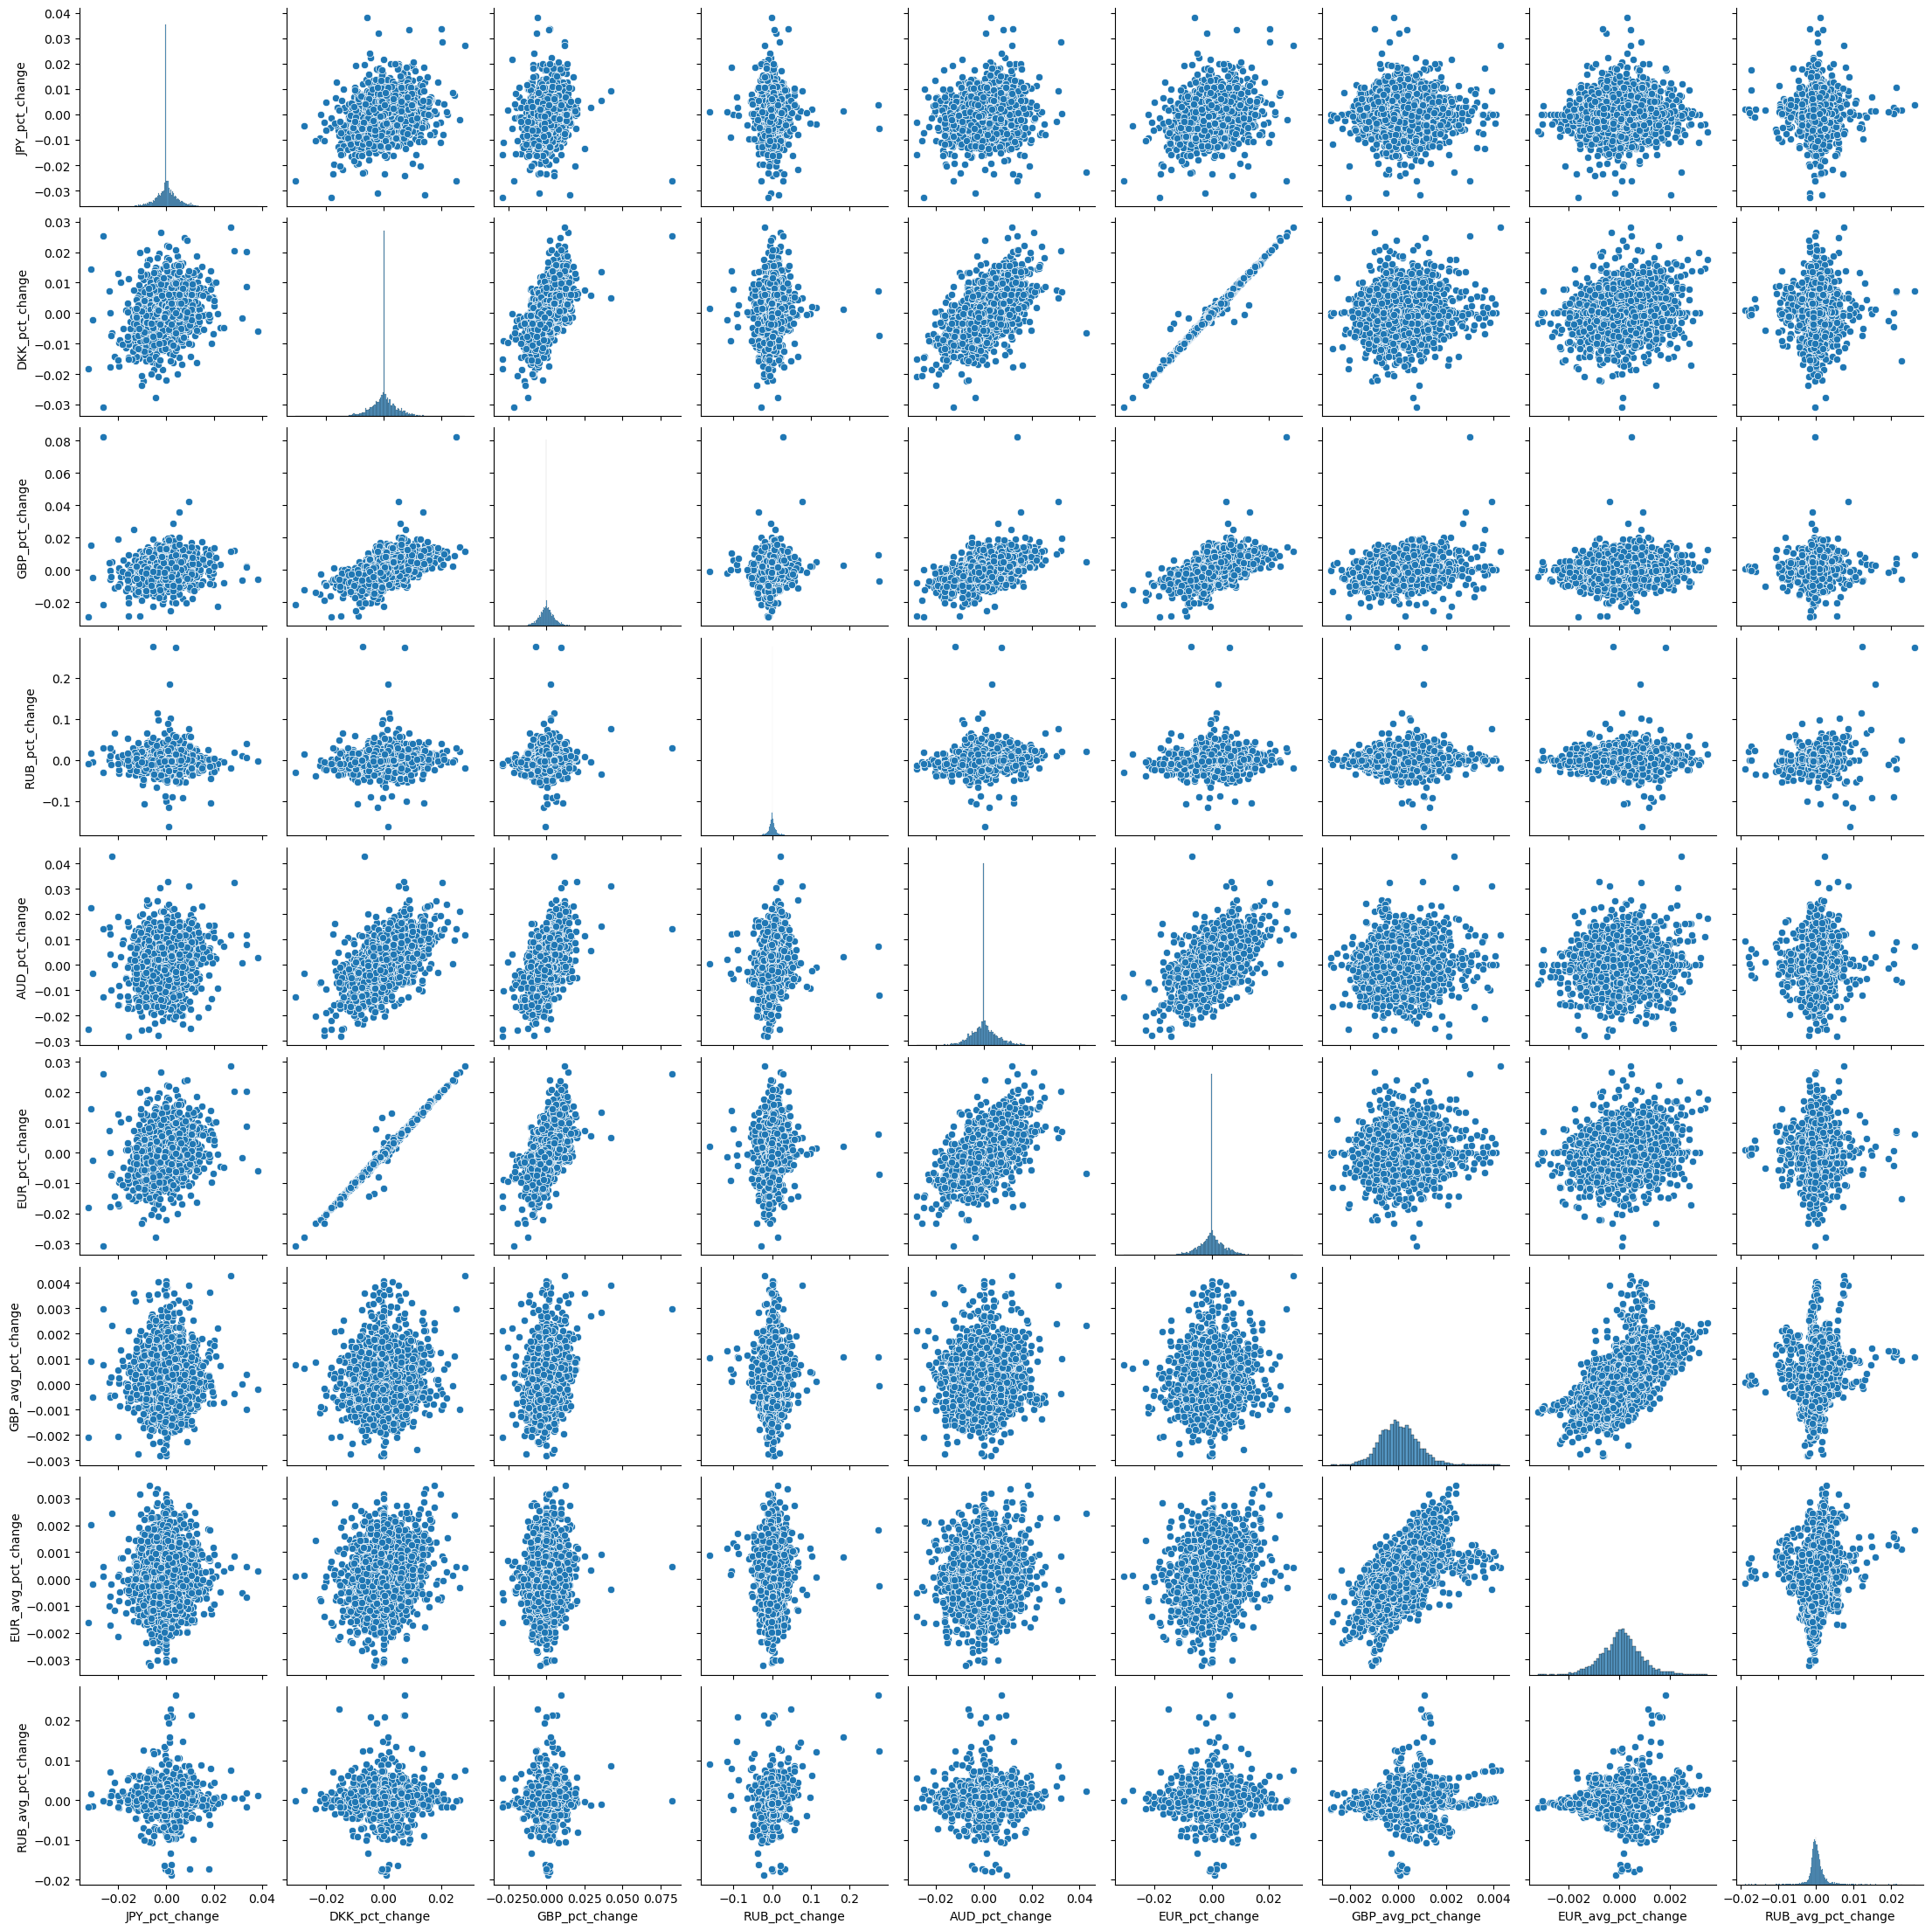

In [8]:
sns.pairplot(pct_df.dropna(axis=0))
plt.show()

### Machine Learning

Our chosen machine learning tools were Linear Regression and Multiple Regression.

### Regression for percent change analysis

Regression was chosen as we wanted to see if there was a linear relationship between the percentage change of the Euro and the Pound. We chose these currencies as they are extremely popular and both used in Europe, and even with the British exit from the European Union, it is useful to see the data up until and after this exit.

In [9]:
def r2_scoring(df, col1, col2, n_splits):
    x = np.array(df[col1])[1:].reshape(-1, 1)
    y = np.array(df[col2])[1:]
    
    kfold = KFold(n_splits=n_splits)

    reg = LinearRegression()

    y_pred = np.empty_like(y)

    for train_idx, test_idx in kfold.split(x, y):
        # get training data
        x_train = x[train_idx, :]
        y_train = y[train_idx]
        
        # get test data    
        x_test = x[test_idx, :]

        # fit data
        reg = reg.fit(x_train, y_train)

        # estimate on test data
        y_pred[test_idx] = reg.predict(x_test)
    
    return r2_score(y_true=y, y_pred=y_pred)

In [10]:
r2_scoring(pct_df, 'GBP_pct_change', 'EUR_pct_change', 10)

0.331558960247777

In [11]:
def randomness_test(df, col1, col2):
    '''
    This function checks the independence of 2 columns of the percent change df
    Parameters: df - dataframe, col1 and col2 - strings with col names
    Returns x and y lists, slope and intercept floats, and makes plots
    '''
    #Checking Independence
    # getting rid of na vals and reshaping
    x_na = np.array(df[col1])
    x = x_na[np.logical_not(np.isnan(x_na))].reshape((-1, 1))
    
    # getting rid of na vals
    y_na = np.array(df[col2])
    y = y_na[np.logical_not(np.isnan(y_na))]
    
    reg = LinearRegression()
    reg.fit(x, y)

    # same as b_1
    slope = reg.coef_[0]

    # same as b_0
    intercept = reg.intercept_
    
    y_pred_bmg = slope * x + intercept
    
    # plotting using index and error vals
    errors = y.reshape((-1,1)) - y_pred_bmg
    plt.scatter(x = range(len(y)), y = errors)
    plt.xlabel('index')
    plt.ylabel('errors')
    plt.show()
    
    # Checking Constant Variance
    plt.scatter(x = x, y = errors)
    plt.xlabel(col1)
    plt.ylabel('errors')
    plt.show()
    
    # Checking Normality
    stats.probplot(errors.reshape((-1,)), dist="norm", plot=py)
    py.show()
    
    return x, y, slope, intercept

In [12]:
def get_mse(y_true, y_pred):
    '''
    Calculates the mean squared distance between the predicted and actual y
    Takes 2 lists, y_true and y_pred
    Returns a mean squared error value
    '''
    # calculate the mean squared distance between the predicted and actual y
    return np.mean((y_pred - y_true) ** 2)

def show_fit(x, y, slope, intercept):
    '''
    This function creates a linear regression
    Parameters - x and y are lists, slope and intercept are floats
    Returns nothing, creates a linear regression plot
    '''
    plt.figure()
    
    # transform the input data into numpy arrays and flatten them for easier processing
    x = np.array(x).ravel()
    y = np.array(y).ravel()
    
    # plot the actual data
    plt.scatter(x, y, label='data')
    
    # compute linear predictions 
    # x is a numpy array so each element gets multiplied by slope and intercept is added
    y_pred = slope * x + intercept
    
    # plot the linear fit
    plt.plot(x, y_pred, color='black',
             ls=':',
             label='linear fit')
    
    # for each data point plot the error
    '''
    for idx, (x_i, y_i) in enumerate(zip(x, y)):
        plt.plot([x_i, x_i], [y_i, slope * x_i + intercept], 
                 ls='--', lw=3, color='tab:red',
                 label='error' if idx == 0 else "")
    '''
    plt.legend()
    
    plt.xlabel('x')
    plt.ylabel('y')
    
    # print the mean squared error
    y_pred = slope * x + intercept
    mse = get_mse(y_true=y, y_pred=y_pred)
    R2_easy = r2_score(y_true=y, y_pred=y_pred)
    plt.suptitle(f'y_hat = {slope:.2f} * x + {intercept:.5f}, RMSE = {mse**0.5:.3f}, R^2 = {R2_easy:.3f}')
    plt.show()

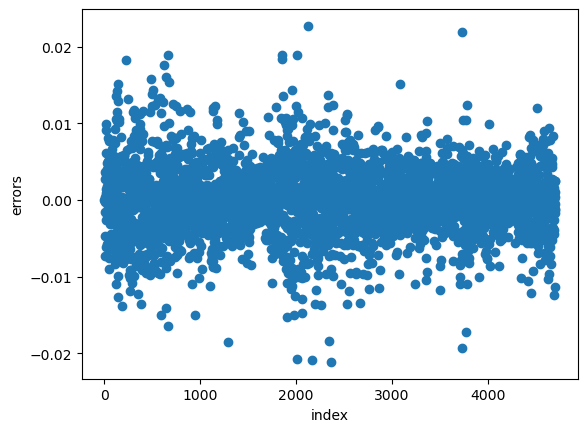

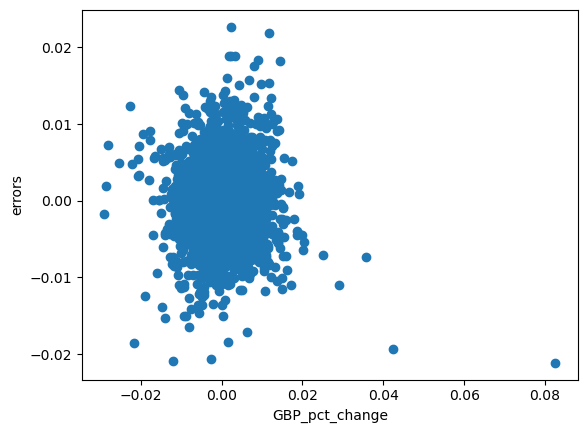

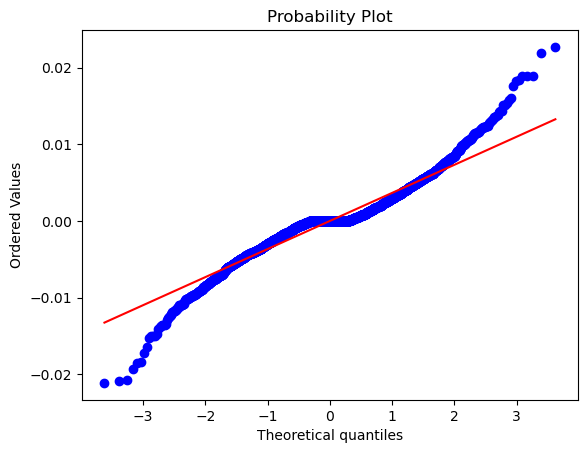

In [13]:
# Testing the data on 3 tests to see if it is random and possible to use a regression on
x, y, slope, intercept = randomness_test(pct_df, 'GBP_pct_change', 'EUR_pct_change')

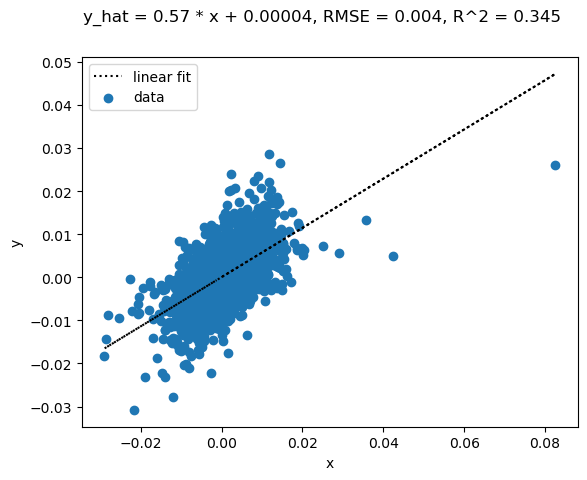

In [14]:
show_fit(x, y, slope, intercept)


In [15]:
# Now looking at the DKK and the EUR
r2_scoring(pct_df, 'DKK_pct_change', 'EUR_pct_change', 10)

0.9902432605598619

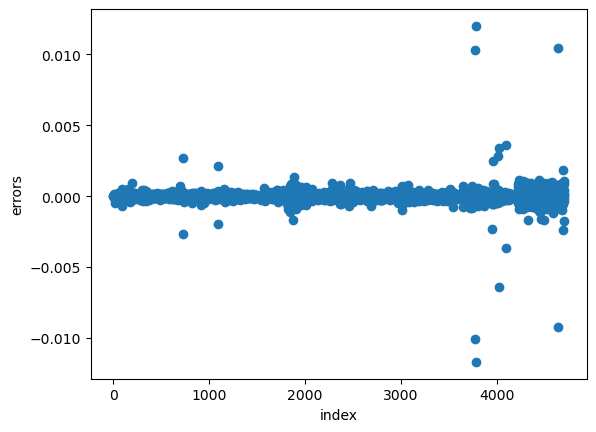

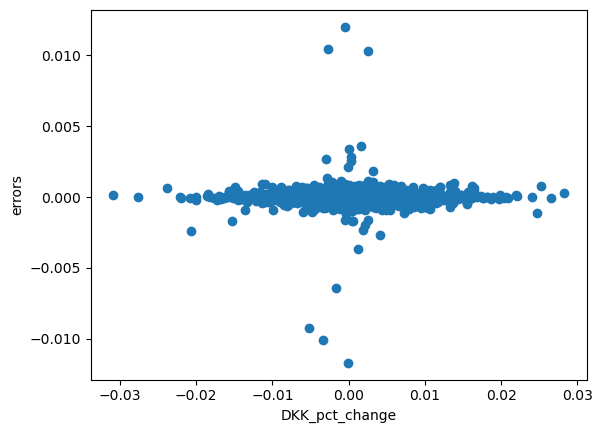

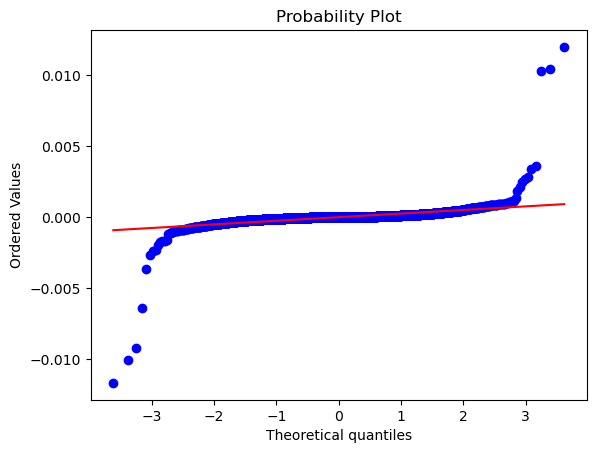

In [16]:
# Now testing DKK and EUR data on 3 tests to see if it is random and possible to use a regression on
x, y, slope, intercept = randomness_test(pct_df, 'DKK_pct_change', 'EUR_pct_change')

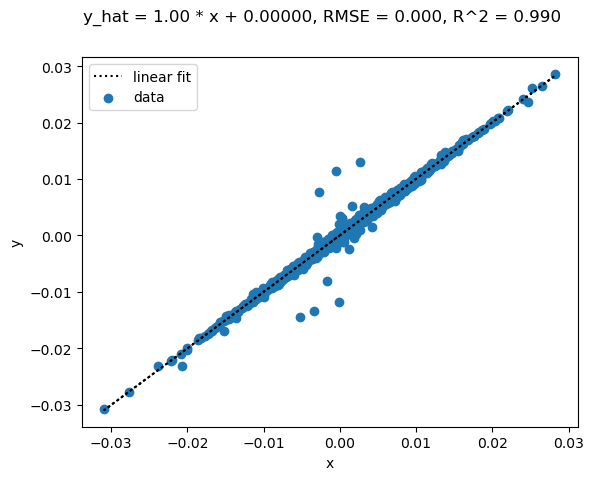

In [17]:
show_fit(x, y, slope, intercept)

### Results

As seen above, we created Linear regression plots and calculated R2 scores for the percentage changes between the Pound the Euro, and then the Krone and the Euro. It is interesting to note that the plots for the GBP vs. EUR pass the randomness test, however they produce a R2 value of only 0.34. With 10 KFolds, this R2 score slightly decreases to 0.33. Although there is a positive relationship between the change in the Pound and a change in the Euro, only around 34% of the variability in 	$\Delta$EUR can be explained by $\Delta$GBP.

To put this into perspective, we conducted the same tests on the Danish Krone and the Euro. Denmark is country that is part of the European Union yet chooses to use their own currency, so this is perfect for comparison against the Pound. $\Delta$DKK against $\Delta$EUR shows an R2 value of 0.99, meaning 99% of the variability in 	$\Delta$EUR can be explained by $\Delta$GBP. This is fantastic, except after a further look at the data through 3 randomness tests, we see that this is because the Krone and the Pound are not random. In fact, with further research, our results prove the fact that the Krone is pegged to the Euro. According to the Danish National Bank, "...the value of the Danish krone is to be kept stable against the euro", due to their monetary policy.

Source: https://www.nationalbanken.dk/en/about_danmarks_nationalbank/frequently_asked_questions/Pages/Denmarks-fixed-exchange-rate-policy.aspx#:~:text=Denmark%20conducts%20a%20fixed%20exchange%20rate%20policy%20against%20the%20euro,by%20way%20of%20monetary%20policy.

### Multiple regression for percent change analysis

Multiple regression was chosen as we wanted to see if there was a relationship between the percentage changes of the EU non-Euro countries and the Euro. We chose these currencies as it is rare for EU countries to use their own, and we wanted to see if any relationships existed.

In [18]:
def disp_regress(df, x_feat_list, y_feat, verbose=True):
    """ linear regression, displays model w/ coef
    
    Args:
        df (pd.DataFrame): dataframe
        x_feat_list (list): list of all features in model
        y_feat (list): target feature
        verbose (bool): toggles command line output
        
    Returns:
        reg (LinearRegression): model fit to data
    """
    # initialize regression object
    reg = LinearRegression()

    # get target variable
    x = df.loc[:, x_feat_list].values
    y = df.loc[:, y_feat].values

    # fit regression
    reg.fit(x, y)

    # compute / store r2
    y_pred = reg.predict(x)
    
    if verbose:
        # print model  
        model_str = y_feat + f' = {reg.intercept_:.2f}'
        for feat, coef in zip(x_feat_list, reg.coef_):
            model_str += f' + {coef:.2f} {feat}'
        print(model_str)

        # compute / print r2
        r2 = r2_score(y_true=y, y_pred=y_pred)
        print(f'r2 = {r2:.3}')
    
    return reg

In [26]:
eu_df = merge_df_by_years(2010, 2022, symbols='EUR,BGN,HRK,CZK,HUF,PLN,RON,SEK', base='USD')
eu_pct_df, pct_concated = calc_pct_change(eu_df)

currencies = [x+'_pct_change' for x in ['BGN','HRK','CZK','HUF','PLN','RON','SEK']]
eu_r2 = disp_regress(eu_pct_df[1:], x_feat_list = currencies, y_feat = 'EUR_pct_change')

EUR_pct_change = 0.00 + 0.04 BGN_pct_change + 0.10 HRK_pct_change + 0.33 CZK_pct_change + 0.07 HUF_pct_change + 0.09 PLN_pct_change + 0.03 RON_pct_change + 0.15 SEK_pct_change
r2 = 0.86


### Random Forrest Regressor on multiple features

In [28]:
y_feat = 'EUR_pct_change'
x_feat_list = currencies

# initialize regression object
rand_forest_regressor = RandomForestRegressor()

# get target variable
x = eu_pct_df[1:].loc[:, x_feat_list].values
y = eu_pct_df[1:].loc[:, y_feat].values

# fit regression
rand_forest_regressor.fit(x, y)

# compute / store r2
y_pred = rand_forest_regressor.predict(x)

# compute r2
r2 = r2_score(y_true=y, y_pred=y_pred)
print(f'r2 = {r2:.3}')

r2 = 0.994


In [29]:
def plot_feat_import(feat_list, feat_import, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    plt.xlabel('Feature importance\n(Mean decrease in MSE across all Decision Trees)')

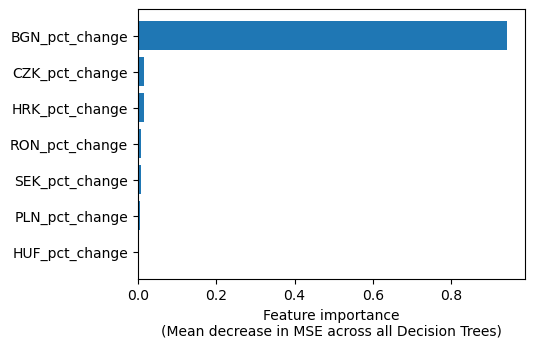

In [30]:
plot_feat_import(x_feat_list, rand_forest_regressor.feature_importances_, limit=10)

#### Removing the Bulgarian Lev at is pegged to the Euro

In [33]:
y_feat = 'EUR_pct_change'
# removing the bulgarian lev
x_feat_list = currencies[1:]

# initialize regression object
rand_forest_regressor = RandomForestRegressor()

# get target variable
x = eu_pct_df[1:].loc[:, x_feat_list].values
y = eu_pct_df[1:].loc[:, y_feat].values

# fit regression
rand_forest_regressor.fit(x, y)

# compute / store r2
y_pred = rand_forest_regressor.predict(x)

# compute r2
r2 = r2_score(y_true=y, y_pred=y_pred)
print(f'r2 = {r2:.3}')

r2 = 0.989


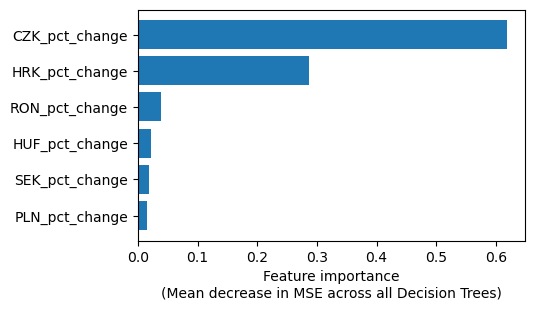

In [35]:
plot_feat_import(x_feat_list, rand_forest_regressor.feature_importances_, limit=10)

### Results

As seen above, we created Multiple Linear regression plots and calculated the R2 scores for the percentage changes between the non-Euro EU countries and the Euro. These 7 countries were the Bulgaria, Croatia, Czech Republic, Hungary, Poland, Romania, and Sweden. Denmark was not included in this calculation as they are on the opt-out system, not in the non Euro area.

Through a Random Forest Regressor, we found that these features have a 0.99 r2. With a value this high, we deployed a feature importance graph and found that the Bulgarian had an extremely significant feature importance. Through further research, this currency was found to be pegged on the Euro, with Bulgaria having a plan to adopt the Euro by 2024.

Next, the Lev was removed and the RFR was run on the other currencies. Producing an r2 value of 0.98, this was extremely interesting as it shows a strong level of variability explanation. The Czech Koruna, with the highest level of feature importance, does not have a peg to the Euro, conveying a very important affect.

Source: https://european-union.europa.eu/institutions-law-budget/euro/countries-using-euro_en